In [ ]:
!pip install kagglehub torch torchvision -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from torch import nn
import kagglehub
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Anime & Sketch Datasets

anime_path = kagglehub.dataset_download("vincentv/anime-style-transfer")
sketch_path = kagglehub.dataset_download("almightyj/person-face-sketches")

print("Path to Anime Style Dataset:", anime_path)
print("Path to Sketch Style Dataset:", sketch_path)

Path to Anime Style Dataset: /kaggle/input/anime-style-transfer
Path to Sketch Style Dataset: /kaggle/input/person-face-sketches


In [ ]:
# Pre-processing & DataLoaders

latent_dim   = 32
lr           = 1e-3
weight_decay = 1e-5
num_epochs   = 20
IMG_SIZE     = 64
beta_final   = 1.0

anime_root  = '/root/.cache/kagglehub/datasets/vincentv/anime-style-transfer/versions/2'
sketch_root = '/root/.cache/kagglehub/datasets/almightyj/person-face-sketches/versions/2'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class PairedDataset(Dataset):
    def __init__(self, root_dir, input_subfolder, target_subfolder, transform=None):
        self.input_dir  = os.path.join(root_dir, input_subfolder)
        self.target_dir = os.path.join(root_dir, target_subfolder)
        self.files      = sorted(os.listdir(self.input_dir))
        self.transform  = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_in  = Image.open(os.path.join(self.input_dir,  fname)).convert('RGB')
        img_out = Image.open(os.path.join(self.target_dir, fname)).convert('RGB')
        if self.transform:
            img_in  = self.transform(img_in)
            img_out = self.transform(img_out)
        return img_in, img_out

In [ ]:
# Anime Style DataLoaders

anime_base = os.path.join(anime_root, 'anime-style-transfer')

def make_anime_loader(split, bs=32):
    base = os.path.join(anime_root, 'anime-style-transfer', split)
    return DataLoader(
        PairedDataset(base, 'images', 'labels', transform),
        batch_size=bs,
        shuffle=(split=='train'),
        num_workers=0,
        pin_memory=True
    )


anime_train_loader = make_anime_loader('train')
anime_test_loader  = make_anime_loader('test')


# Sketch Style DataLoaders

def make_sketch_loader(split, bs=32):
    return DataLoader(
        PairedDataset(sketch_root, f'{split}/photos', f'{split}/sketches', transform),
        batch_size=bs,
        shuffle=(split=='train'),
        num_workers=0,
        pin_memory=True
    )

sketch_train_loader = make_sketch_loader('train')
sketch_test_loader  = make_sketch_loader('test')


for name, loader in [
    ('anime_train',  anime_train_loader),
    ('anime_test',   anime_test_loader),
    ('sketch_train', sketch_train_loader),
    ('sketch_test',  sketch_test_loader),
]:
    x, y = next(iter(loader))
    print(f"{name}: in {x.shape}, out {y.shape}")

anime_train: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])
anime_test: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])
sketch_train: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])
sketch_test: in torch.Size([32, 3, 64, 64]), out torch.Size([32, 3, 64, 64])


In [ ]:
# VAE

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32,64, 4,2,1),   nn.ReLU(True),
            nn.Conv2d(64,128,4,2,1),   nn.ReLU(True),
            nn.Conv2d(128,256,4,2,1),  nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_mu     = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256,4,4)),
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1),  nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,2,1),   nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,2,1),    nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h      = self.encoder(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z      = self.reparameterize(mu, logvar)
        recon  = self.decoder(self.decoder_input(z))
        return recon, mu, logvar

def vae_loss(recon, target, mu, logvar, beta):
    recon_l = nn.functional.mse_loss(recon, target, reduction='sum')
    kl      = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_l + beta*kl) / recon.size(0)

In [ ]:
# Train/Test Function

def run_training(model, optimizer, train_loader, test_loader):
    scheduler    = torch.optim.lr_scheduler.ReduceLROnPlateau(
                       optimizer, mode='min', factor=0.5, patience=3)
    best_test    = float('inf')
    patience_cnt = 0

    for epoch in range(1, num_epochs+1):
        beta = min(beta_final, epoch*(beta_final/10))

        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader, desc=f"Train {epoch}/{num_epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, y, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in tqdm(test_loader, desc=f"Test  {epoch}/{num_epochs}"):
                x, y = x.to(device), y.to(device)
                recon, mu, logvar = model(x)
                test_loss += vae_loss(recon, y, mu, logvar, beta).item()
        test_loss /= len(test_loader)

        print(f"Epoch {epoch:02d} | β={beta:.2f} "
              f"Train {train_loss:.1f}  Test {test_loss:.1f}")
        scheduler.step(test_loss)

In [ ]:
# Anime Training

anime_vae = ConvVAE(latent_dim).to(device)
anime_opt = torch.optim.Adam(anime_vae.parameters(), lr=lr, weight_decay=weight_decay)
run_training(anime_vae, anime_opt,
             anime_train_loader, anime_test_loader)

Train 1/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  1/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 01 | β=0.10 Train 3780.0  Test 3415.9


Train 2/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  2/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02 | β=0.20 Train 2900.4  Test 2488.0


Train 3/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  3/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03 | β=0.30 Train 2397.1  Test 2317.0


Train 4/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  4/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04 | β=0.40 Train 2205.2  Test 2137.1


Train 5/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  5/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05 | β=0.50 Train 2135.3  Test 2094.6


Train 6/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  6/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06 | β=0.60 Train 2107.1  Test 2113.7


Train 7/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  7/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07 | β=0.70 Train 2064.4  Test 2043.0


Train 8/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  8/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08 | β=0.80 Train 2042.4  Test 2059.4


Train 9/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  9/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09 | β=0.90 Train 2045.2  Test 2029.2


Train 10/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  10/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 | β=1.00 Train 2034.0  Test 2033.3


Train 11/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  11/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 | β=1.00 Train 2020.3  Test 2021.9


Train 12/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  12/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 | β=1.00 Train 1998.4  Test 1999.6


Train 13/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  13/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 | β=1.00 Train 1988.9  Test 2001.1


Train 14/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  14/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 | β=1.00 Train 1988.2  Test 1971.6


Train 15/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  15/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 | β=1.00 Train 1967.7  Test 2031.9


Train 16/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  16/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 | β=1.00 Train 1958.4  Test 2006.0


Train 17/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  17/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 | β=1.00 Train 1963.0  Test 1950.7


Train 18/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  18/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 | β=1.00 Train 1952.9  Test 1973.7


Train 19/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  19/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 | β=1.00 Train 1949.5  Test 1987.9


Train 20/20:   0%|          | 0/26 [00:00<?, ?it/s]

Test  20/20:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 | β=1.00 Train 1941.9  Test 1960.8


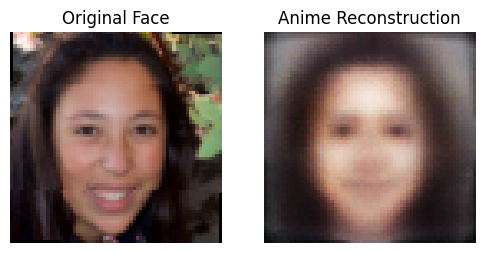

In [ ]:
# Testing Anime Style Transformation

def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor.clamp(0,1)

img_path = '/content/drive/My Drive/test_face.jpg'
pil_img  = Image.open(img_path).convert('RGB')
x = transform(pil_img).unsqueeze(0).to(device)

with torch.no_grad():
    recon, mu, logvar = anime_vae(x)

inp = denormalize(x.cpu())[0]
out = denormalize(recon.cpu())[0]

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].imshow(inp.permute(1,2,0))
axs[0].set_title('Original Face');  axs[0].axis('off')
axs[1].imshow(out.permute(1,2,0))
axs[1].set_title('Anime Reconstruction'); axs[1].axis('off')
plt.show()

In [ ]:
# Sketch Training Loop

num_epochs = 10

sketch_vae = ConvVAE(latent_dim).to(device)
sketch_opt = torch.optim.Adam(sketch_vae.parameters(), lr=lr, weight_decay=weight_decay)
run_training(sketch_vae, sketch_opt,
             sketch_train_loader, sketch_test_loader)

Train 1/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  1/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 01 | β=0.10 Train 1927.8  Test 1701.7


Train 2/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  2/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 02 | β=0.20 Train 1725.6  Test 1725.2


Train 3/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  3/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 03 | β=0.30 Train 1715.4  Test 1682.2


Train 4/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  4/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 04 | β=0.40 Train 1700.5  Test 1689.4


Train 5/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  5/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 05 | β=0.50 Train 1689.8  Test 1650.9


Train 6/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  6/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 06 | β=0.60 Train 1692.8  Test 1676.9


Train 7/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  7/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 07 | β=0.70 Train 1681.9  Test 1672.7


Train 8/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  8/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 08 | β=0.80 Train 1678.7  Test 1658.1


Train 9/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  9/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 09 | β=0.90 Train 1685.7  Test 1641.9


Train 10/10:   0%|          | 0/646 [00:00<?, ?it/s]

Test  10/10:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 | β=1.00 Train 1677.2  Test 1654.5


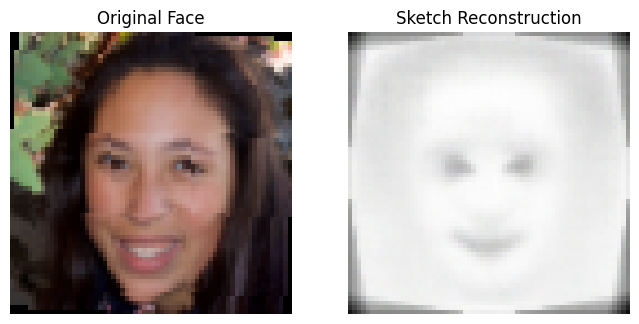

In [ ]:
# Testing Sketch Style Transformation

def denormalize(tensor):
    t = tensor * 0.5 + 0.5
    return t.clamp(0,1)

img_path = '/content/drive/My Drive/test_face.jpg'
pil_img  = Image.open(img_path).convert('RGB')
x = transform(pil_img).unsqueeze(0).to(device)

with torch.no_grad():
    recon, mu, logvar = sketch_vae(x)

inp = denormalize(x.cpu().squeeze(0))
out = denormalize(recon.cpu().squeeze(0))

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(inp.permute(1,2,0))
axs[0].set_title('Original Face')
axs[0].axis('off')

axs[1].imshow(out.permute(1,2,0))
axs[1].set_title('Sketch Reconstruction')
axs[1].axis('off')

plt.show()